In [2]:
import numpy as np
import emcee
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
import corner
from IPython.display import display, Math

In [19]:
data = np.genfromtxt('D1_c_5.dat')
m=data.shape[0]
x=np.zeros(m)
y=np.zeros(m)
sigma=np.zeros(m)
for i in range(data.shape[0]):
    x[i]=data[i][0]
    y[i]=data[i][1]
    sigma[i] = data[i][2]

In [4]:
def log_prior_uni(a):
    if -100 < a.all() < 100:
        return 0.0
    return -np.inf
    
def log_prior_gauss(a, abar=5):
    gauss = (1 / (np.sqrt(2 * np.pi)*abar)) ** k * np.exp(- a**2 / (2 * abar**2))
    return np.sum(np.log(gauss))

def g(a, x, k):
    g = 0
    for i in range(k):
        g += a[i] * x**i
    return g

def chi_squared(a, x, y, sigma):
    return np.sum(((y - g(a, x, k)) / sigma) ** 2)

def log_likelihood(a, x, y, sigma):
    return np.sum(np.log(1 / ( np.sqrt(2 * np.pi) * sigma))) - chi_squared(a, x, y, sigma) / 2
    
def log_posterior_uni(a, x, y, sigma):
    lp_uni = log_prior_uni(a)
    if not np.isfinite(lp_uni):
        return -np.inf
    return lp_uni + log_likelihood(a, x, y, sigma)

def log_posterior_gauss(a, x, y, sigma):
    return log_prior_gauss(a, k) + log_likelihood(a, x, y, sigma)

In [5]:
k = 4
theta_start = np.zeros(k)

fun = lambda *args: -log_likelihood(*args)
initial = theta_start + 0.1 * np.random.randn(k)
sol = minimize(fun, initial, args=(x, y, sigma))

In [6]:
starting_guesses = [sol.x] + 1e-4 * np.random.randn(50, k)

nwalkers, ndim = starting_guesses.shape

sampler_uni = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_uni, args=(x, y, sigma))

sampler_uni.run_mcmc(starting_guesses, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 373.88it/s]


In [7]:
starting_guesses = np.ones(k) + 1e-4 * np.random.randn(50, k)

nwalkers, ndim = starting_guesses.shape

sampler_gauss = emcee.EnsembleSampler(nwalkers, ndim, log_posterior_gauss, args=(x, y, sigma))

sampler_gauss.run_mcmc(starting_guesses, 5000, progress=True);

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 335.09it/s]


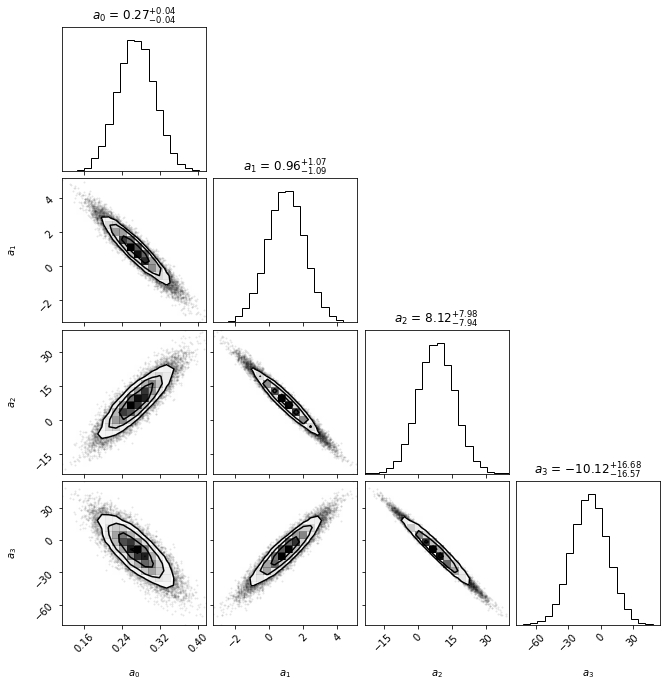

In [8]:
flat_samples_uni = sampler_uni.get_chain(discard=100, thin=15, flat=True)

labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"]
    
fig = corner.corner(flat_samples_uni, labels=labels, titles=labels, show_titles=True);

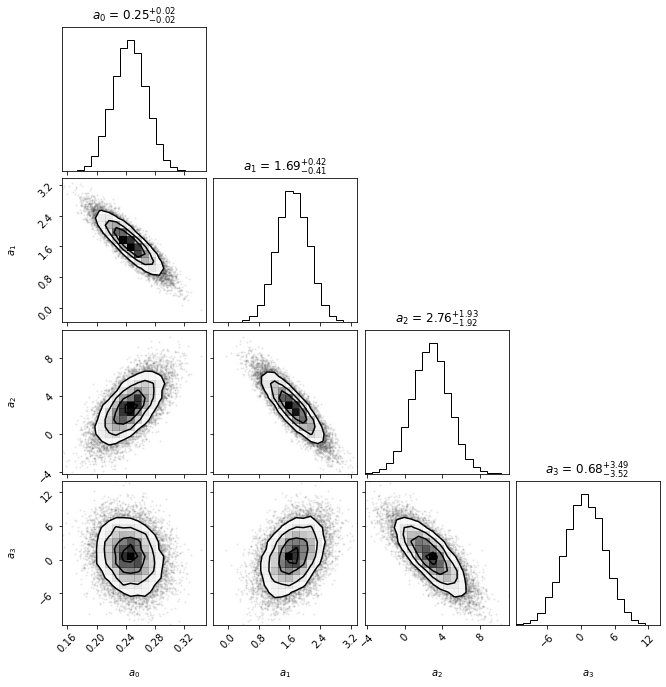

In [9]:
flat_samples_gauss = sampler_gauss.get_chain(discard=100, thin=15, flat=True)

labels = [r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"]
    
fig = corner.corner(flat_samples_gauss, labels=labels, titles=labels, show_titles=True);

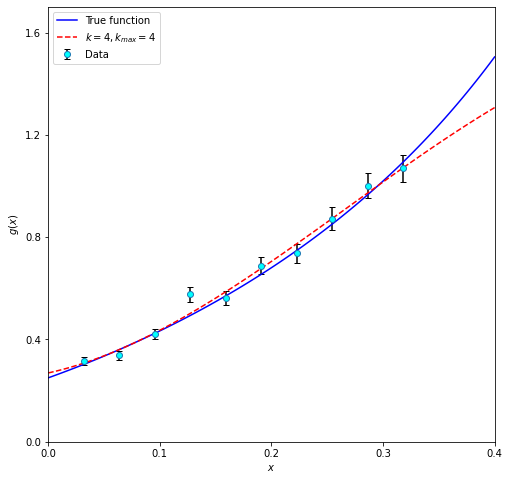

In [79]:
fig = plt.figure(figsize=(8, 8))
plt.errorbar(x, y, (sigma), fmt="o", label="Data", ecolor="black", capsize=3.0, mfc='aqua')
plt.xlim(0.0, 0.4)
plt.xticks(np.linspace(0.0, 0.4, 5))
plt.xlabel(r"$x$")
plt.ylim(0.0, 1.7)
plt.yticks(np.linspace(0.0, 1.6, 5))
plt.ylabel(r"$g(x)$")
x_range = np.linspace(0.0, 0.4, 100)
func = ((1 / 2) + np.tan(np.pi/2 * x_range))**2
plt.plot(x_range, func, label=r"True function", color="b")
a = sol.x
plt.plot(x_range, g(a, x_range, k=4), 'r--', label=r"$k=4, k_{max}=4$")
plt.legend(loc='upper left');